# 4장

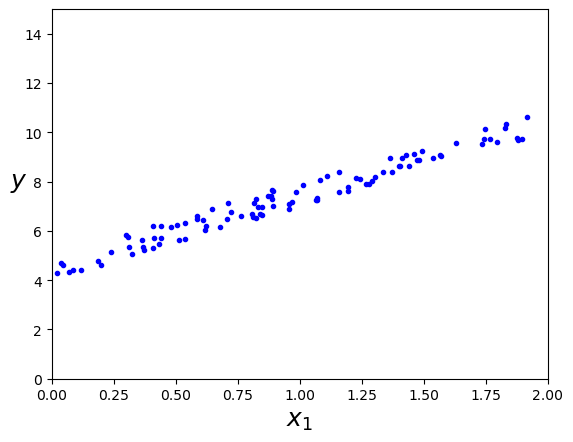

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show(block=False)
plt.pause(2)
plt.close()

In [2]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[4.41431341]
 [3.03111554]]


[[ 4.41431341]
 [10.47654449]]


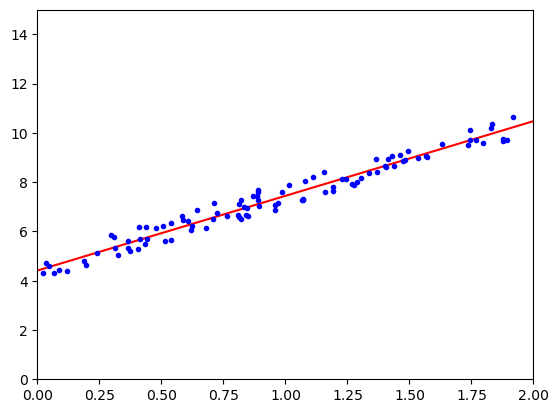

In [3]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
print(y_predict)

plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show(block=False)
plt.pause(2)
plt.close()

In [4]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.41431341] [[3.03111554]]
[[ 4.41431341]
 [10.47654449]]


In [5]:
# 유사역행렬 계산
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

[[4.41431341]
 [3.03111554]]


In [6]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

print(theta)

[[4.41431341]
 [3.03111554]]


In [7]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

# theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print(theta)

[[4.42349232]
 [3.02460269]]


In [8]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.38373223] [3.0612218]


In [9]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

# theta = np.random.randn(2, 1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

print(theta)

[[4.41549155]
 [3.03105539]]


In [10]:
from sklearn.preprocessing import PolynomialFeatures

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X_poly[0])

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[-1.26734619] [-1.26734619  1.60616636]
[2.07219655] [[0.99080617 0.48079923]]


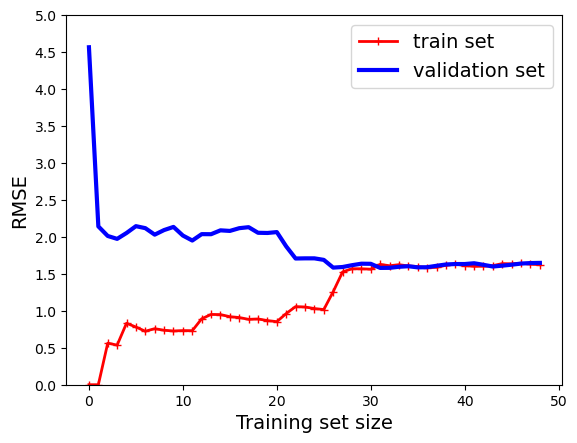

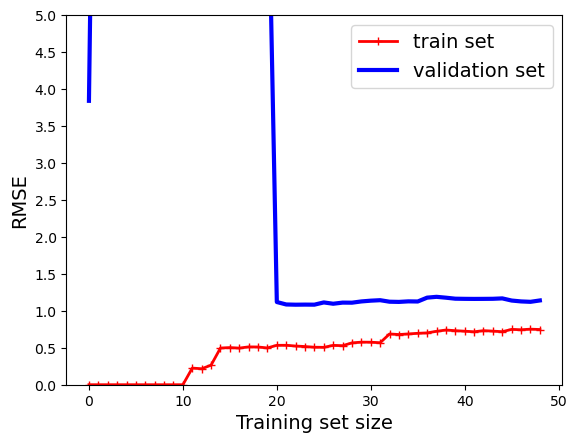

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train set')

    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='validation set')
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

    # Set y-axis ticks
    plt.yticks(np.arange(0, 5.5, 0.5))
    # Set y-axis limits
    plt.ylim(0, 5)
    plt.show(block=False)
    plt.pause(2)
    plt.close()
    
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('lin_reg', LinearRegression())
])
# 과소적합
plot_learning_curves(polynomial_regression, X, y)

# 과대적합
polynomial_regression.set_params(poly_features__degree=10)
plot_learning_curves(polynomial_regression, X, y)

In [12]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

sgd_reg = SGDRegressor(penalty='l2', random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[[5.19739302]]
[5.19095834]


In [13]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1, random_state=42)
lasso_reg.fit(X, y)
print(lasso_reg.predict([[1.5]]))

sgd_reg = SGDRegressor(penalty='l1', random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.predict([[1.5]]))

[5.16078615]
[5.19095839]


In [14]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
# l1_ratio: 혼합 비율(r). 0=릿지, 1=라쏘.
elastic_net.fit(X, y)
print(elastic_net.predict([[1.5]]))

[5.16128892]


In [15]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate='constant', eta0=0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
print(best_epoch, epoch)
print(minimum_val_error, val_error)

500 999
3.0084537510614826 4.076109259914396


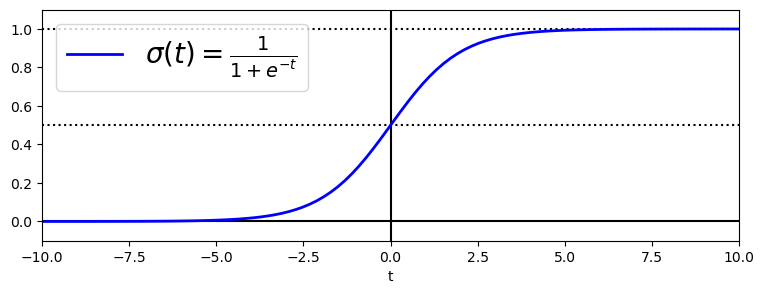

In [16]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show(block=False)
plt.pause(2)
plt.close()

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']


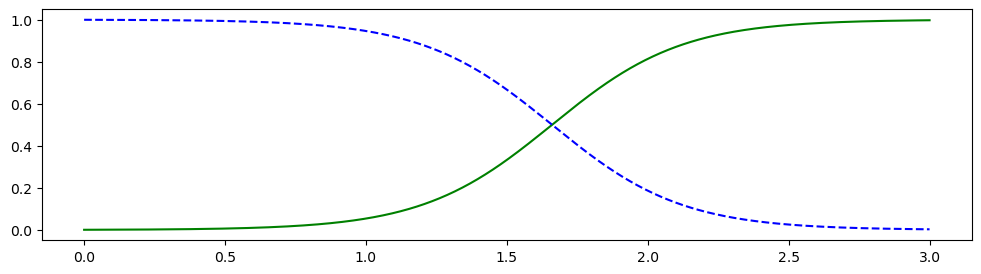

In [17]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
print(list(iris.keys()))
X = iris['data'][:, 3:]
y = (iris['target']==2).astype(int)

log_reg = LogisticRegression()
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.figure(figsize=(12,3))
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris virginica')
plt.show(block=False)
plt.pause(2)
plt.close()

In [18]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.21626371e-07 5.73689802e-02 9.42630398e-01]]
